In [21]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms  # 使用v1版本
import torchvision.io as tv_io
import glob
from PIL import Image
from sklearn.metrics import precision_score, recall_score, mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [3]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights).to(device)

In [4]:
# 冻结基础模型的参数
for param in vgg_model.parameters():
    param.requires_grad = False

In [5]:
N_CLASSES = 7

my_model = nn.Sequential(
    vgg_model.features,
    vgg_model.avgpool,
    nn.Flatten(),
    vgg_model.classifier[0:3],
    nn.Linear(4096, 500),
    nn.ReLU(),
    nn.Linear(500, N_CLASSES)
).to(device)

In [6]:
# 定义损失函数和优化器
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(my_model.parameters(), lr=0.001)

In [7]:
# 学习率调度器
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [8]:
# 数据增强与预处理
IMG_WIDTH, IMG_HEIGHT = (224, 224)
random_trans = transforms.Compose([
    transforms.RandomResizedCrop(size=(IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
DATA_LABELS = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

class MyDataset(Dataset):
    def __init__(self, data_dir):
        self.imgs = []
        self.labels = []
        for l_idx, label in enumerate(DATA_LABELS):
            data_paths = glob.glob(data_dir + label + '/*.jpg', recursive=True)
            for path in data_paths:
                # 使用 PIL.Image 打开图像并进行转换
                img = Image.open(path).convert('RGB')
                img = random_trans(img)  # 应用数据增强变换
                self.imgs.append(img.to(device))
                self.labels.append(torch.tensor(l_idx).to(device))

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [10]:
n = 32
train_path = "picture/train/"
train_data = MyDataset(train_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)

valid_path = "picture/val/"
valid_data = MyDataset(valid_path)
valid_loader = DataLoader(valid_data, batch_size=n, shuffle=False)

In [12]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [13]:
def train(model, data_loader, loss_function):
    model.train()
    running_loss = 0.0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    return running_loss / len(data_loader)

In [22]:
def validate(model, valid_loader):
    model.eval()  # 设置模型为评估模式
    all_labels = []
    all_predictions = []
    loss_total = 0.0

    with torch.no_grad():  # 在验证时不计算梯度
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_function(output, y)
            loss_total += loss.item()

            # 获取预测结果
            _, predicted = torch.max(output.data, 1)
            all_labels.extend(y.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = loss_total / len(valid_loader)

    # 计算准确率
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()

    # 计算精确率和召回率
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)

    # 计算均方误差 (MSE) 和平均绝对误差 (MAE)
    mse = mean_squared_error(all_labels, all_predictions)
    mae = mean_absolute_error(all_labels, all_predictions)

    print(f'Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}')

    return avg_loss


In [24]:
epochs = 50
early_stopping = EarlyStopping(patience=10, verbose=True)

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    
    train_loss = train(my_model, train_loader, loss_function)
    print(f'Train Loss: {train_loss:.4f}')
    
    val_loss = validate(my_model, valid_loader)
    
    early_stopping(val_loss)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch: 0
Train Loss: 1.0629
Validation Loss: 1.3371, Accuracy: 0.5052, Precision: 0.5037, Recall: 0.5052, MSE: 4.0912, MAE: 1.2449
Epoch: 1
Train Loss: 1.0507
Validation Loss: 1.3455, Accuracy: 0.5043, Precision: 0.4954, Recall: 0.5043, MSE: 4.2672, MAE: 1.2764
EarlyStopping counter: 1 out of 10
Epoch: 2
Train Loss: 1.0434
Validation Loss: 1.3491, Accuracy: 0.5077, Precision: 0.5022, Recall: 0.5077, MSE: 4.1013, MAE: 1.2416
EarlyStopping counter: 2 out of 10
Epoch: 3
Train Loss: 1.0387
Validation Loss: 1.3573, Accuracy: 0.5040, Precision: 0.4967, Recall: 0.5040, MSE: 4.0971, MAE: 1.2413
EarlyStopping counter: 3 out of 10
Epoch: 4
Train Loss: 1.0256
Validation Loss: 1.3711, Accuracy: 0.5040, Precision: 0.5075, Recall: 0.5040, MSE: 4.1933, MAE: 1.2605
EarlyStopping counter: 4 out of 10
Epoch: 5
Train Loss: 1.0146
Validation Loss: 1.3528, Accuracy: 0.5149, Precision: 0.5120, Recall: 0.5149, MSE: 4.0589, MAE: 1.2271
EarlyStopping counter: 5 out of 10
Epoch: 6
Train Loss: 1.0143
Validation 

In [25]:
# 解冻基础模型进行微调
for param in vgg_model.parameters():
    param.requires_grad = True

optimizer = Adam(my_model.parameters(), lr=0.0001)

In [26]:
# 微调训练过程
for epoch in range(10): 
    print('Fine-tuning Epoch: {}'.format(epoch))
    
    train(my_model, train_loader, loss_function)
    
    validate(my_model, valid_loader)

Fine-tuning Epoch: 0


/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation Loss: 1.1081, Accuracy: 0.5760, Precision: 0.5817, Recall: 0.5760, MSE: 3.6577, MAE: 1.0904
Fine-tuning Epoch: 1
Validation Loss: 1.0456, Accuracy: 0.5997, Precision: 0.6201, Recall: 0.5997, MSE: 3.7874, MAE: 1.0817
Fine-tuning Epoch: 2
Validation Loss: 1.0047, Accuracy: 0.6223, Precision: 0.6382, Recall: 0.6223, MSE: 3.4622, MAE: 1.0064
Fine-tuning Epoch: 3
Validation Loss: 0.9780, Accuracy: 0.6477, Precision: 0.6416, Recall: 0.6477, MSE: 2.8756, MAE: 0.8812
Fine-tuning Epoch: 4
Validation Loss: 1.1355, Accuracy: 0.6435, Precision: 0.6424, Recall: 0.6435, MSE: 3.0142, MAE: 0.9082
Fine-tuning Epoch: 5
Validation Loss: 1.2182, Accuracy: 0.6296, Precision: 0.6411, Recall: 0.6296, MSE: 3.3414, MAE: 0.9788
Fine-tuning Epoch: 6
Validation Loss: 1.3633, Accuracy: 0.6374, Precision: 0.6502, Recall: 0.6374, MSE: 3.1174, MAE: 0.9339
Fine-tuning Epoch: 7
Validation Loss: 1.4708, Accuracy: 0.6432, Precision: 0.6449, Recall: 0.6432, MSE: 2.9654, MAE: 0.9018
Fine-tuning Epoch: 8
Validati

正在验证的图像: picture/test/neutral/3656.jpg


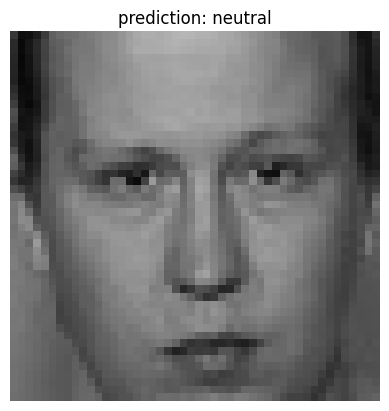

angry: 0.1967
disgust: 0.0034
fear: 0.0481
happy: 0.0002
neutral: 0.6114
sad: 0.1401
surprise: 0.0002


In [32]:
import random
import os
import matplotlib.pyplot as plt

# 定义数据预处理步骤
def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 调整图像大小
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
    ])
    
    image = Image.open(image_path).convert('RGB')  # 打开图像并转换为RGB格式
    image_tensor = transform(image).unsqueeze(0)  # 添加批次维度
    return image_tensor.to(device), image  # 返回张量和原始图像

# 从test文件夹中随机选择一张图片进行验证
def test_random_image(model, test_dir):
    all_images = []
    
    # 收集所有类别的图像路径
    for label in DATA_LABELS:
        label_dir = os.path.join(test_dir, label)
        if os.path.exists(label_dir):
            all_images.extend(glob.glob(os.path.join(label_dir, '*.jpg')))  # 假设图像为jpg格式

    if not all_images:
        print("没有找到测试图像！")
        return
    
    random_image_path = random.choice(all_images)  # 随机选择一张图像
    print(f"正在验证的图像: {random_image_path}")

    image_tensor, original_image = load_and_preprocess_image(random_image_path)  # 加载和预处理图像

    model.eval()  # 设置模型为评估模式
    with torch.no_grad():
        output = model(image_tensor)  # 获取模型输出
        probabilities = torch.softmax(output, dim=1)  # 获取每个类别的概率
        prediction_idx = output.argmax(dim=1).item()  # 获取预测类别索引

    # 显示原始图像和预测结果
    plt.imshow(original_image)
    plt.axis('off')  # 不显示坐标轴
    plt.title(f"prediction: {DATA_LABELS[prediction_idx]}")
    plt.show()

    # 输出每个标签的概率
    for i, label in enumerate(DATA_LABELS):
        print(f"{label}: {probabilities[0][i].item():.4f}")  # 输出格式化的概率值

# 调用函数进行验证，指定测试目录路径
test_directory = "picture/test/"  # 测试图像所在目录
test_random_image(my_model, test_directory)